In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df=pd.read_csv('Shenzhen_Clean.csv')

In [22]:
df

,Year,Month,Day,Month #,Day #,Week#,Kitchen waste (t),Fruit and vegetable waste (t),Bread Paste (t),Waste oil (t),...,#3 Contact Oxidation Cell Dissolved Oxygen (mg/L),Daily electricity consumption (kWh)4,Circulating liquid PH value,Maximum tower temperature (℃),Minimum tower temperature (℃),Air intake H2S content (PPM),Exhaust H2S content (PPM),Daily water consumption (m³)3,TotalElecCons,TotalWaterCons
0,2015.0,December,1.0,1.0,1.0,1.0,92.03,0.00,7.95,13.54,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1696.203577,11.76
1,2015.0,December,2.0,1.0,2.0,1.0,78.43,0.00,13.30,16.10,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1761.454597,9.92
2,2015.0,December,3.0,1.0,3.0,1.0,81.84,0.00,8.35,6.60,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1812.982114,6.91
3,2015.0,December,4.0,1.0,4.0,1.0,81.05,0.00,9.10,17.48,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1661.635705,7.63
4,2015.0,December,5.0,1.0,5.0,1.0,36.86,0.00,9.40,12.47,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1776.042619,7.90
5,2015.0,December,6.0,1.0,6.0,1.0,21.58,0.00,16.20,11.85,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1803.684918,0.00
6,2015.0,December,7.0,1.0,7.0,1.0,89.98,0.00,9.10,12.14,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1644.025789,8.72
7,2015.0,December,8.0,1.0,8.0,2.0,80.46,9.80,16.90,13.92,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1642.099996,9.85
8,2015.0,December,9.0,1.0,9.0,2.0,77.20,10.40,5.60,10.69,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1815.511611,8.95
9,2015.0,December,10.0,1.0,10.0,2.0,78.37,9.34,8.30,9.79,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1843.732297,9.61


In [23]:
df=df.drop(df.index[456:463])

In [24]:
df

,Year,Month,Day,Month #,Day #,Week#,Kitchen waste (t),Fruit and vegetable waste (t),Bread Paste (t),Waste oil (t),...,#3 Contact Oxidation Cell Dissolved Oxygen (mg/L),Daily electricity consumption (kWh)4,Circulating liquid PH value,Maximum tower temperature (℃),Minimum tower temperature (℃),Air intake H2S content (PPM),Exhaust H2S content (PPM),Daily water consumption (m³)3,TotalElecCons,TotalWaterCons
0,2015.0,December,1.0,1.0,1.0,1.0,92.03,0.00,7.95,13.54,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1696.203577,11.76
1,2015.0,December,2.0,1.0,2.0,1.0,78.43,0.00,13.30,16.10,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1761.454597,9.92
2,2015.0,December,3.0,1.0,3.0,1.0,81.84,0.00,8.35,6.60,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1812.982114,6.91
3,2015.0,December,4.0,1.0,4.0,1.0,81.05,0.00,9.10,17.48,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1661.635705,7.63
4,2015.0,December,5.0,1.0,5.0,1.0,36.86,0.00,9.40,12.47,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1776.042619,7.90
5,2015.0,December,6.0,1.0,6.0,1.0,21.58,0.00,16.20,11.85,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1803.684918,0.00
6,2015.0,December,7.0,1.0,7.0,1.0,89.98,0.00,9.10,12.14,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1644.025789,8.72
7,2015.0,December,8.0,1.0,8.0,2.0,80.46,9.80,16.90,13.92,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1642.099996,9.85
8,2015.0,December,9.0,1.0,9.0,2.0,77.20,10.40,5.60,10.69,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1815.511611,8.95
9,2015.0,December,10.0,1.0,10.0,2.0,78.37,9.34,8.30,9.79,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1843.732297,9.61


In [25]:
df.isnull()

,Year,Month,Day,Month #,Day #,Week#,Kitchen waste (t),Fruit and vegetable waste (t),Bread Paste (t),Waste oil (t),...,#3 Contact Oxidation Cell Dissolved Oxygen (mg/L),Daily electricity consumption (kWh)4,Circulating liquid PH value,Maximum tower temperature (℃),Minimum tower temperature (℃),Air intake H2S content (PPM),Exhaust H2S content (PPM),Daily water consumption (m³)3,TotalElecCons,TotalWaterCons
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,False,False


In [9]:
print(df.dtypes)

Year                                                   float64
Month                                                   object
Day                                                    float64
Month #                                                float64
Day #                                                  float64
Week#                                                  float64
Kitchen waste (t)                                      float64
Fruit and vegetable waste (t)                          float64
Bread Paste (t)                                        float64
Waste oil (t)                                          float64
Total Waste (t)                                        float64
Daily landfilled amount (t)                            float64
Diesel waste water (m³)                                float64
Flour and waste oil (m³)                               float64
Kitchen waste paste (m³)                               float64
Daily water consumption (m³)                           

In [26]:
del df['Maximum tower temperature (℃)']
del df['Minimum tower temperature (℃)']
df.head()

,Year,Month,Day,Month #,Day #,Week#,Kitchen waste (t),Fruit and vegetable waste (t),Bread Paste (t),Waste oil (t),...,#1 Contact Oxidation Cell Dissolved Oxygen (mg/L),#2 Contact Oxidation Cell Dissolved Oxygen (mg/L),#3 Contact Oxidation Cell Dissolved Oxygen (mg/L),Daily electricity consumption (kWh)4,Circulating liquid PH value,Air intake H2S content (PPM),Exhaust H2S content (PPM),Daily water consumption (m³)3,TotalElecCons,TotalWaterCons
0,2015.0,December,1.0,1.0,1.0,1.0,92.03,0.0,7.95,13.54,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1696.203577,11.76
1,2015.0,December,2.0,1.0,2.0,1.0,78.43,0.0,13.30,16.10,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1761.454597,9.92
2,2015.0,December,3.0,1.0,3.0,1.0,81.84,0.0,8.35,6.60,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1812.982114,6.91
3,2015.0,December,4.0,1.0,4.0,1.0,81.05,0.0,9.10,17.48,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1661.635705,7.63
4,2015.0,December,5.0,1.0,5.0,1.0,36.86,0.0,9.40,12.47,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1776.042619,7.90


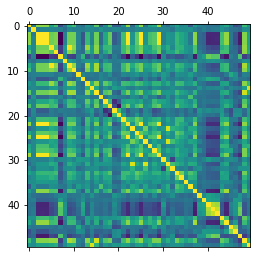

In [27]:
df.corr()
plt.matshow(df.corr()) 

In [68]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd

class MiceImputer:
    
    model_dict_ = {}
    
    def __init__(self, seed_nulls=False, seed_strategy='mean'):
        self.seed_nulls = seed_nulls
        self.seed_strategy = seed_strategy
        
    
    def transform(self, X):
        col_order = X.columns
        new_X = []
        mutate_cols = list(self.model_dict_.keys())
        
        for i in mutate_cols:
            y = X[i]
            x_null = X[y.isnull()]
            y_null = y[y.isnull()].reset_index()['index']
            y_notnull = y[y.notnull()]
            
            model = self.model_dict_.get(i)
            
            if self.seed_nulls:
                x_null = model[1].transform(x_null)
            else:
                null_check = x_null.isnull().any()
                x_null = x_null[null_check.index[~null_check]]
            
            pred = pd.concat([pd.Series(model[0].predict(x_null))\
                              .to_frame()\
                              .set_index(y_null),y_notnull], axis=0)\
                              .rename(columns={0: i})
            
            new_X.append(pred)

        new_X.append(X[X.columns.difference(mutate_cols)])

        final = pd.concat(new_X, axis=1)[col_order]

        return final
        
        
    def fit(self, X):      
        x = X.fillna(value=np.nan)

        null_check = x.isnull().any()
        null_data = x[null_check.index[null_check]]
        
        for i in null_data:
            y = null_data[i]
            y_notnull = y[y.notnull()]

            model_list = []
            if self.seed_nulls:
                imp = Imputer(strategy=self.seed_strategy)
                model_list.append(imp.fit(x))
                non_null_data = pd.DataFrame(imp.fit_transform(x))
                
            else:
                non_null_data = x[null_check.index[~null_check]]
                
            
            x_notnull = non_null_data[y.notnull()]
            
            if y.nunique() > 2:
                model = LinearRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})
            else:
                model = LogisticRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})

        return self
        

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [74]:
imputer = MiceImputer()
del df['Month']
df = imputer.fit_transform(df)
df

,Year,Day,Month #,Day #,Week#,Kitchen waste (t),Fruit and vegetable waste (t),Bread Paste (t),Waste oil (t),Total Waste (t),...,#1 Contact Oxidation Cell Dissolved Oxygen (mg/L),#2 Contact Oxidation Cell Dissolved Oxygen (mg/L),#3 Contact Oxidation Cell Dissolved Oxygen (mg/L),Daily electricity consumption (kWh)4,Circulating liquid PH value,Air intake H2S content (PPM),Exhaust H2S content (PPM),Daily water consumption (m³)3,TotalElecCons,TotalWaterCons
0,2015.0,1.0,1.0,1.0,1.0,92.03,0.00,7.95,13.54,99.98,...,0.00,0.00,0.00,0.0,0.00,-4175.138855,-1485.068720,45.367762,1696.203577,11.76
1,2015.0,2.0,1.0,2.0,1.0,78.43,0.00,13.30,16.10,91.73,...,0.00,0.00,0.00,0.0,0.00,-3972.674234,-1438.142950,49.796827,1761.454597,9.92
2,2015.0,3.0,1.0,3.0,1.0,81.84,0.00,8.35,6.60,90.19,...,0.00,0.00,0.00,0.0,0.00,-4283.267859,-1284.809461,49.197063,1812.982114,6.91
3,2015.0,4.0,1.0,4.0,1.0,81.05,0.00,9.10,17.48,90.15,...,0.00,0.00,0.00,0.0,0.00,-4873.839567,-1510.251571,50.855989,1661.635705,7.63
4,2015.0,5.0,1.0,5.0,1.0,36.86,0.00,9.40,12.47,46.26,...,0.00,0.00,0.00,0.0,0.00,-4568.135123,-1322.405456,48.491175,1776.042619,7.90
5,2015.0,6.0,1.0,6.0,1.0,21.58,0.00,16.20,11.85,37.78,...,0.00,0.00,0.00,0.0,0.00,-5672.041244,-1793.629281,55.564243,1803.684918,0.00
6,2015.0,7.0,1.0,7.0,1.0,89.98,0.00,9.10,12.14,99.08,...,0.00,0.00,0.00,0.0,0.00,-4981.654950,-1377.274739,50.425284,1644.025789,8.72
7,2015.0,8.0,1.0,8.0,2.0,80.46,9.80,16.90,13.92,107.16,...,0.00,0.00,0.00,0.0,0.00,-5808.395471,-1846.372395,54.148026,1642.099996,9.85
8,2015.0,9.0,1.0,9.0,2.0,77.20,10.40,5.60,10.69,93.20,...,0.00,0.00,0.00,0.0,0.00,-4866.589691,-1463.570950,50.440543,1815.511611,8.95
9,2015.0,10.0,1.0,10.0,2.0,78.37,9.34,8.30,9.79,96.01,...,0.00,0.00,0.00,0.0,0.00,-4654.804697,-1355.183739,48.870516,1843.732297,9.61
